In [393]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import *
import datetime
import statsmodels.api as sm
from statsmodels.tsa import stattools



import warnings
warnings.filterwarnings('ignore')
os.chdir("C:/Users/danil/Desktop/ИТМО/Лаба/Дата для анализа спроса")

In [394]:
# данные для нулевой пиццерии с агрегацией на весь день
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']
df

,value
2022-01-01,651
2022-01-02,626
2022-01-03,336
2022-01-04,308
2022-01-05,337
...,...
2023-09-26,466
2023-09-27,513
2023-09-28,563
2023-09-29,699


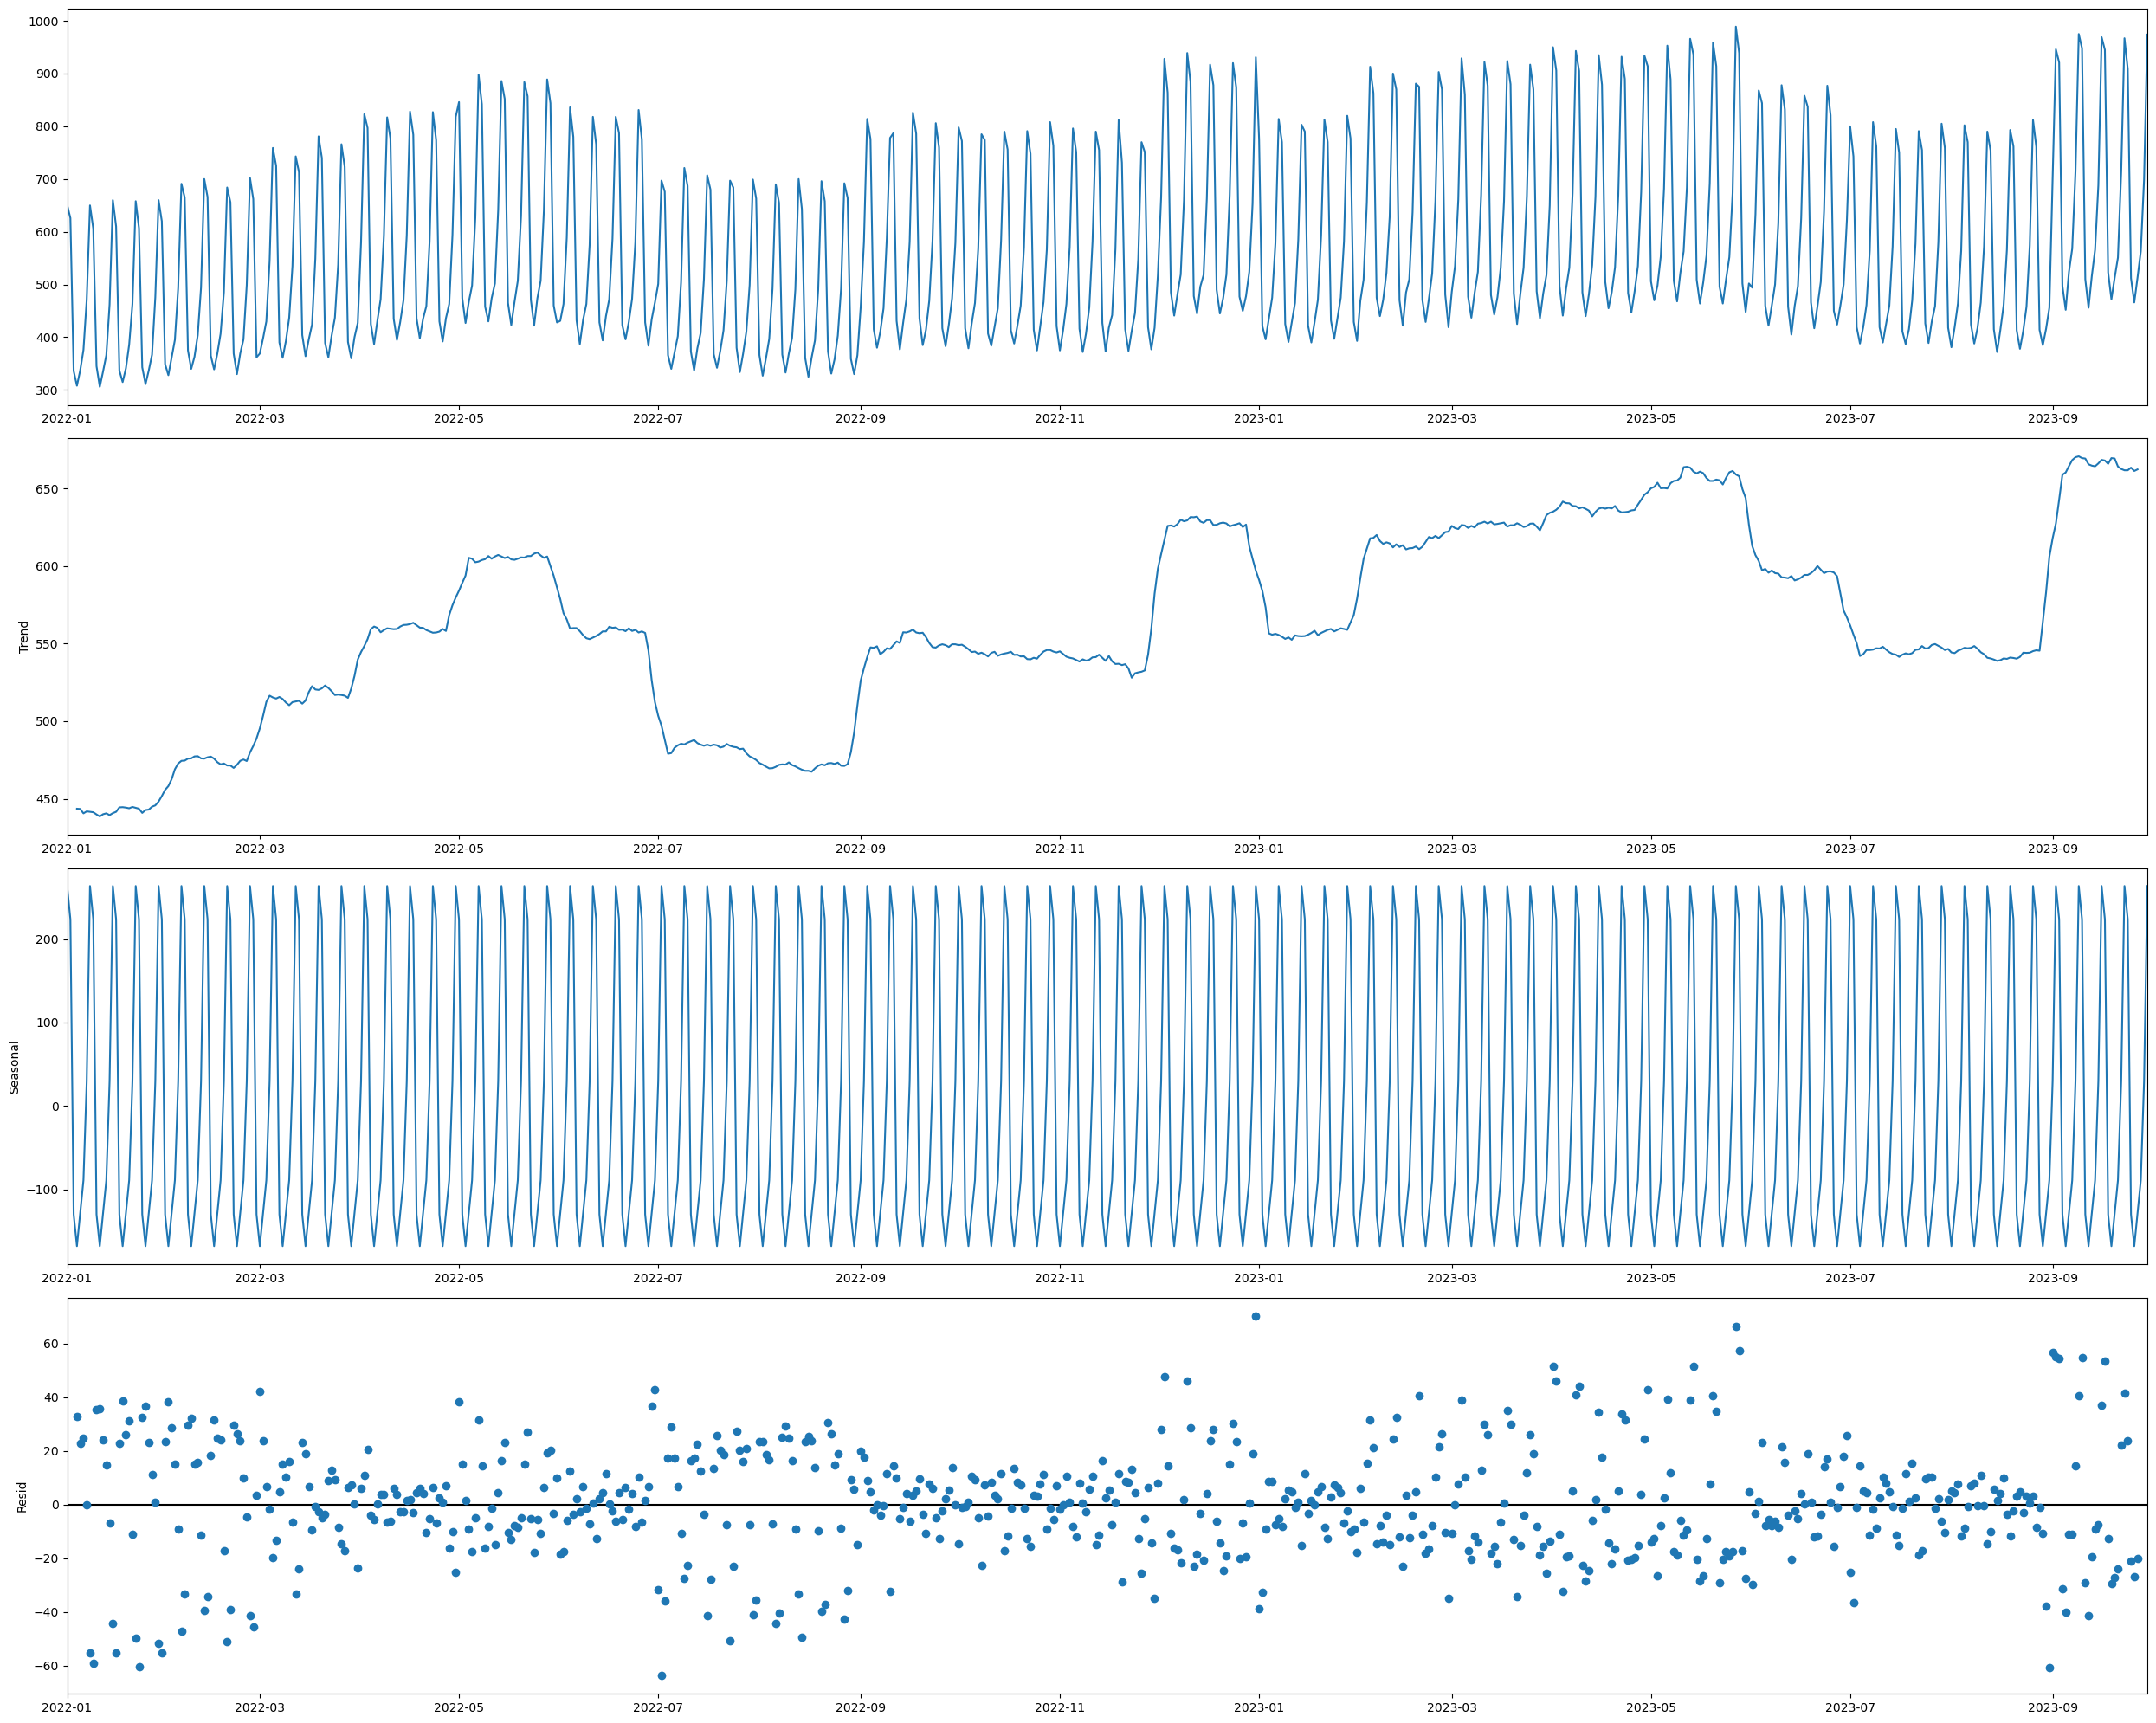

In [395]:
# разложение ряда на тренд, сезонную часть и остатки
res = sm.tsa.seasonal_decompose(df)
plt.rc("figure", figsize=(25,20))
resplot = res.plot()

In [396]:
# Тест Дики-Фуллера для доказательства нестационарности ряда

df_stat = stattools.adfuller(df)

print('The Augmented Dickey-Fuller test statistic %f, \npvalue: %.2f\ncritical values: %s' %
      (df_stat[0], df_stat[1], df_stat[4]))

if df_stat[0] > df_stat[4]['5%']:
    print('Есть единичные корни - ряд нестационарный') # 100% верно
else:
    print('Единичных корней нет, ряд стационарен') # не всегда верно

The Augmented Dickey-Fuller test statistic -2.348911, 
pvalue: 0.16
critical values: {'1%': -3.440890045708521, '5%': -2.8661904001753618, '10%': -2.569246579178572}
Есть единичные корни - ряд нестационарный


Prophet

In [397]:
from prophet import Prophet

df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']
Train = df.loc[:'09.15.2023']
Test = df.loc['09.16.2023':]
Train = Train.reset_index()
Test = Test.reset_index()

In [398]:
Test['value'] = np.log(Test['value'])
Train['value'] = np.log(Train['value'])

In [399]:
Train=Train.rename(columns={'index':'ds', 'value':'y'})
Test=Test.rename(columns={'index':'ds', 'value':'y'})

In [400]:
Test

,ds,y
0,2023-09-16,6.876265
1,2023-09-17,6.851185
2,2023-09-18,6.259581
3,2023-09-19,6.156979
4,2023-09-20,6.240276
5,2023-09-21,6.311735
6,2023-09-22,6.570883
7,2023-09-23,6.874198
8,2023-09-24,6.812345
9,2023-09-25,6.238325


In [401]:
model = Prophet(weekly_seasonality=True)
model.fit(Train)

02:33:56 - cmdstanpy - INFO - Chain [1] start processing
02:33:56 - cmdstanpy - INFO - Chain [1] done processing


In [402]:
future = model.make_future_dataframe(periods=15, freq = 'd')
future.tail()

,ds
633,2023-09-26
634,2023-09-27
635,2023-09-28
636,2023-09-29
637,2023-09-30


In [403]:
forecast = model.predict(future)

In [404]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
633,2023-09-26,6.271730,5.894379,6.016334,6.268095,6.276797,-0.315485,-0.315485,-0.315485,-0.315485,-0.315485,-0.315485,0.0,0.0,0.0,5.956244
634,2023-09-27,6.270828,5.995195,6.111441,6.266093,6.276851,-0.220335,-0.220335,-0.220335,-0.220335,-0.220335,-0.220335,0.0,0.0,0.0,6.050494
635,2023-09-28,6.269927,6.079721,6.197087,6.263876,6.277053,-0.130958,-0.130958,-0.130958,-0.130958,-0.130958,-0.130958,0.0,0.0,0.0,6.138969
636,2023-09-29,6.269025,6.300151,6.424094,6.261956,6.277074,0.091725,0.091725,0.091725,0.091725,0.091725,0.091725,0.0,0.0,0.0,6.360750
637,2023-09-30,6.268123,6.632661,6.755577,6.259682,6.277297,0.424337,0.424337,0.424337,0.424337,0.424337,0.424337,0.0,0.0,0.0,6.692460


In [405]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
633,2023-09-26,5.956244,5.894379,6.016334
634,2023-09-27,6.050494,5.995195,6.111441
635,2023-09-28,6.138969,6.079721,6.197087
636,2023-09-29,6.360750,6.300151,6.424094
637,2023-09-30,6.692460,6.632661,6.755577


In [406]:
metric_df = forecast.set_index('ds')[['yhat']].join(Test.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
metric_df

,ds,yhat,y
623,2023-09-16,6.705083,6.876265
624,2023-09-17,6.654181,6.851185
625,2023-09-18,6.055323,6.259581
626,2023-09-19,5.962556,6.156979
627,2023-09-20,6.056805,6.240276
628,2023-09-21,6.145280,6.311735
629,2023-09-22,6.367061,6.570883
630,2023-09-23,6.698771,6.874198
631,2023-09-24,6.647870,6.812345
632,2023-09-25,6.049011,6.238325


In [407]:
mean_absolute_error(metric_df.y, metric_df.yhat)

0.18664773106068566

In [408]:
metrics_df = pd.DataFrame(columns = ['method', 'MAE', 'MAPE', 'MSE', 'RMSE'])
appending_data = {'method': 'Prophet', 'MAE': mean_absolute_error(metric_df.y, metric_df.yhat), 'MAPE': mean_absolute_percentage_error(metric_df.y, metric_df.yhat), 'MSE': mean_squared_error(metric_df.y, metric_df.yhat), 'RMSE': root_mean_squared_error(metric_df.y, metric_df.yhat)} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.03498,0.187029


Lin reg

In [409]:
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']
df

,value
2022-01-01,651
2022-01-02,626
2022-01-03,336
2022-01-04,308
2022-01-05,337
...,...
2023-09-26,466
2023-09-27,513
2023-09-28,563
2023-09-29,699


In [410]:
for i in range(1, 8):
    df[f"lag_{i}"] = df['value'].shift(i)
df.dropna(inplace=True)
df.head()

,value,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
2022-01-08,650,471.0,376.0,337.0,308.0,336.0,626.0,651.0
2022-01-09,606,650.0,471.0,376.0,337.0,308.0,336.0,626.0
2022-01-10,345,606.0,650.0,471.0,376.0,337.0,308.0,336.0
2022-01-11,306,345.0,606.0,650.0,471.0,376.0,337.0,308.0
2022-01-12,335,306.0,345.0,606.0,650.0,471.0,376.0,337.0


In [411]:
# Делаю модель линейной регрессии на временных лагах
Train = df.loc[:'09.15.2023']
Test = df.loc['09.16.2023':]

Test['value'] = np.log(Test['value'])
Train['value'] = np.log(Train['value'])

X_train = Train.drop('value', axis=1)
y_train = Train['value']

X_test = Test.drop('value', axis=1)
y_test = Test['value']

In [412]:
# добавляю в модель линейной регрессии кросс-валилидацию на временных рядах
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression


y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

MAE = []
MAPE = []
MSE = []
RMSE = []


tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    MAE.append(mean_absolute_error(preds, y_test))
    MAPE.append(mean_absolute_percentage_error(preds, y_test))
    MSE.append(mean_squared_error(preds, y_test))
    RMSE.append(root_mean_squared_error(preds, y_test))

In [413]:
appending_data = {'method': 'linear regression with time_series_split', 'MAE': np.mean(MAE), 'MAPE': np.mean(MAPE), 'MSE': np.mean(MSE), 'RMSE': np.mean(RMSE)} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725


In [414]:
# Делаю модель линейной регрессии на временных лагах
Train = df.loc[:'08.31.2023']
Test = df.loc['09.16.2023':]

Test['value'] = np.log(Test['value'])
Train['value'] = np.log(Train['value'])

X_train = Train.drop('value', axis=1)
y_train = Train['value']

X_test = Test.drop('value', axis=1)
y_test = Test['value']

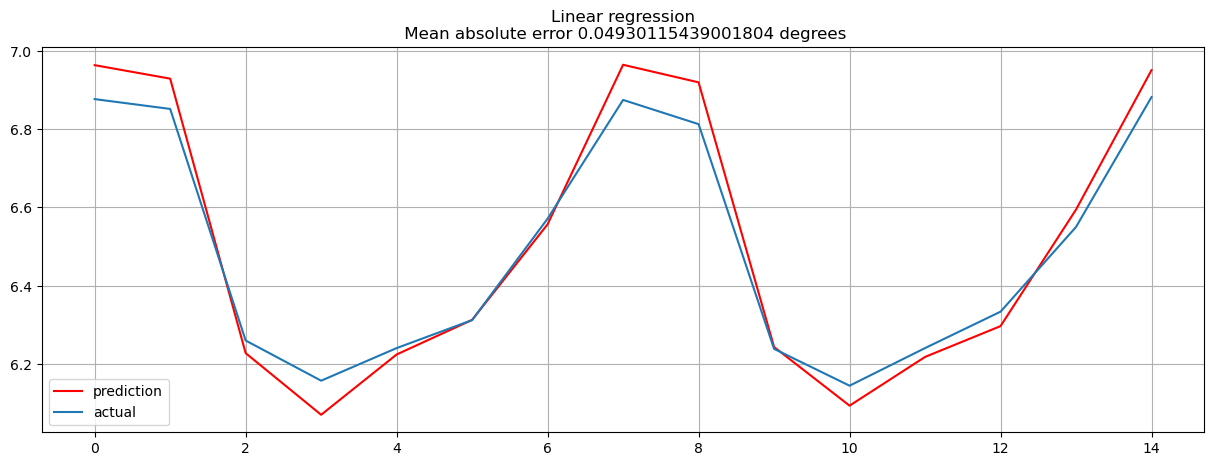

In [415]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [416]:
appending_data = {'method': 'linear regression', 'MAE': mean_absolute_error(preds, y_test), 'MAPE': mean_absolute_percentage_error(preds, y_test), 'MSE': mean_squared_error(preds, y_test), 'RMSE': root_mean_squared_error(preds, y_test)} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580


ETNA

Тинькоффская библиотека для прогнозирования

In [417]:
import etna
from etna.datasets.tsdataset import TSDataset
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df['date'] = df.index
df.index = range(len(df))
df.columns = ['value', 'date']
df['value'] = np.log(df['value'])
df

,value,date
0,6.478510,2022-01-01
1,6.439350,2022-01-02
2,5.817111,2022-01-03
3,5.730100,2022-01-04
4,5.820083,2022-01-05
...,...,...
633,6.144186,2023-09-26
634,6.240276,2023-09-27
635,6.333280,2023-09-28
636,6.549651,2023-09-29


In [418]:
df["timestamp"] = pd.to_datetime(df["date"])
df["target"] = df["value"]
df.drop(columns=["date", "value"], inplace=True)
df["segment"] = "main"
df.head()

,timestamp,target,segment
0,2022-01-01,6.478510,main
1,2022-01-02,6.439350,main
2,2022-01-03,5.817111,main
3,2022-01-04,5.730100,main
4,2022-01-05,5.820083,main


In [419]:
from etna.datasets.tsdataset import TSDataset

df = TSDataset.to_dataset(df)
ts = TSDataset(df, freq="D")

ts.head()

# все эти манипуляции нужны для работы

segment,main
feature,target
timestamp,
2022-01-01,6.478510
2022-01-02,6.439350
2022-01-03,5.817111
2022-01-04,5.730100
2022-01-05,5.820083


In [420]:
train_ts, test_ts = ts.train_test_split(
    train_start="2022-01-01",
    train_end="2023-09-15",
    test_start="2023-09-16",
    test_end="2023-09-30",
)

In [421]:
HORIZON = 15 # горизонт прогнозирования

from etna.models import NaiveModel, CatBoostMultiSegmentModel, LinearPerSegmentModel, SARIMAXModel

# Обучаем этот вид модели
model1 = NaiveModel(lag=5)

model1.fit(train_ts)

# ПРогноз
future_ts = train_ts.make_future(future_steps=HORIZON, tail_steps=model1.context_size)

forecast_ts = model1.forecast(future_ts, prediction_size=HORIZON)

In [422]:
from etna.metrics import *

mae, mape, mse, rmse = MAE(), MAPE(), MSE(), RMSE()

appending_data = {'method': 'NaiveModel', 'MAE': mae(y_true=test_ts, y_pred=forecast_ts)['main'], 'MAPE': mape(y_true=test_ts, y_pred=forecast_ts)['main'], 'MSE': mse(y_true=test_ts, y_pred=forecast_ts)['main'], 'RMSE': rmse(y_true=test_ts, y_pred=forecast_ts)['main']} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580
3,NaiveModel,0.309069,4.648117,0.144704,0.380399


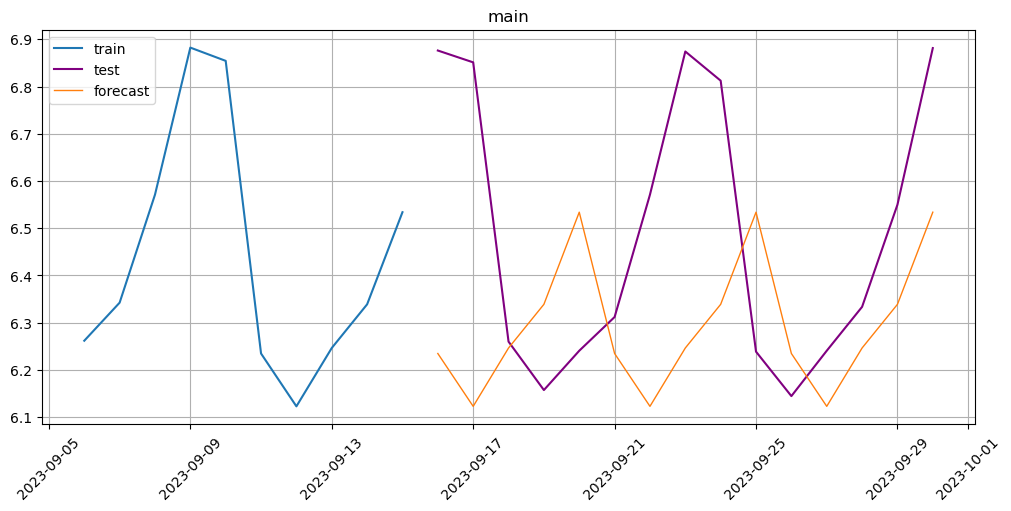

In [423]:
from etna.analysis import plot_forecast

plot_forecast(forecast_ts, test_ts, train_ts, n_train_samples=10)

In [424]:
# модель с пайплайном в виде трансформации ряда и применения модели
# пайплайн с линейной регрессией
from etna.pipeline import Pipeline
from etna.metrics import MAE, SMAPE
from etna.transforms import STLTransform, LagTransform, MeanSegmentEncoderTransform

pipe = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=LinearPerSegmentModel(),
    horizon=3
)

In [425]:
metrics, forecast, _ = pipe.backtest(
    ts=ts, metrics=[MAE(), MAPE(), MSE(), RMSE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Do

,segment,MAE,MAPE,MSE,RMSE,fold_number
0,main,0.028996,0.448909,0.001217,0.034887,0
0,main,0.021935,0.353197,0.000604,0.024574,1
0,main,0.014147,0.208108,0.000303,0.017395,2
0,main,0.007601,0.122944,0.000082,0.009044,3
0,main,0.019370,0.294901,0.000378,0.019431,4


In [426]:
metrics_value = metrics.mean().to_dict()

appending_data = {'method': 'Pipeline: LinearPerSegmentModel with transforming and cross-validation', 'MAE': metrics_value['MAE'], 'MAPE': metrics_value['MAPE'], 'MSE': metrics_value['MSE'], 'RMSE': metrics_value['RMSE']} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580
3,NaiveModel,0.309069,4.648117,0.144704,0.380399
4,Pipeline: LinearPerSegmentModel with transform...,0.018410,0.285612,0.000517,0.021066


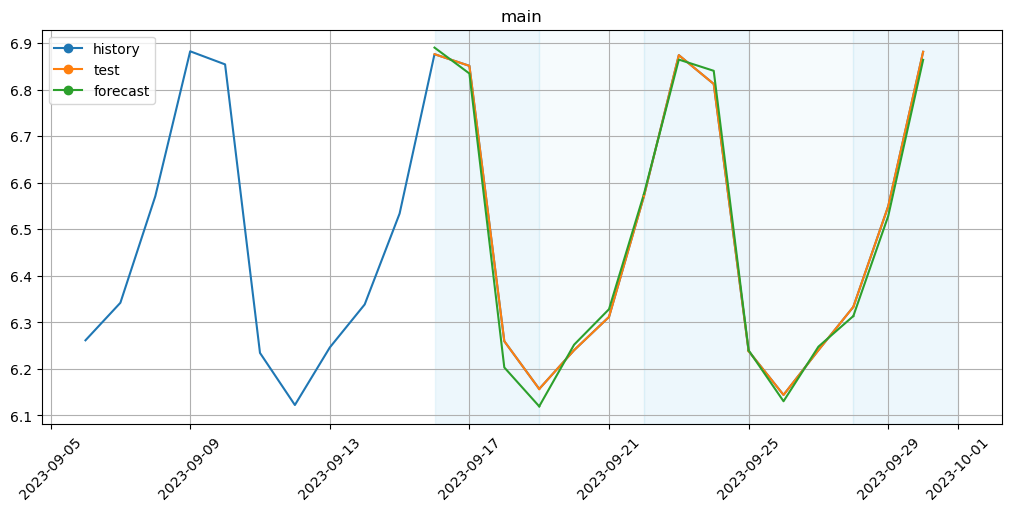

In [427]:
from etna.analysis import plot_backtest

plot_backtest(forecast_df=forecast, ts=ts, history_len=10)

In [428]:
# такие же трансформации, где мы разбиваем ряд на составляющие, а потом добавляем лаги, только теперь используем catboost
pipe2 = Pipeline(
    transforms=[
        STLTransform(in_column="target", period=7, model="arima"),
        LagTransform(in_column="target", lags=list(range(3, 10, 1))),
    ],
    model=CatBoostMultiSegmentModel(n_estimators=1000, learning_rate=0.01),
    horizon=3
)
metrics, forecast, _ = pipe2.backtest(
    ts=ts, metrics=[MAE(), MAPE(), MSE(), RMSE()], n_folds=5)

metrics

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    4.4s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    5.9s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    7.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   5 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   4 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Do

,segment,MAE,MAPE,MSE,RMSE,fold_number
0,main,0.026889,0.417455,0.001113,0.033366,0
0,main,0.018391,0.296269,0.000438,0.020931,1
0,main,0.021713,0.323205,0.000522,0.022841,2
0,main,0.006678,0.108125,0.000067,0.008166,3
0,main,0.017921,0.273065,0.000323,0.017977,4


In [429]:
metrics_value = metrics.mean().to_dict()

appending_data = {'method': 'Pipeline: CatBoostMultiSegmentModel with transforming and cross-validation', 'MAE': metrics_value['MAE'], 'MAPE': metrics_value['MAPE'], 'MSE': metrics_value['MSE'], 'RMSE': metrics_value['RMSE']} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580
3,NaiveModel,0.309069,4.648117,0.144704,0.380399
4,Pipeline: LinearPerSegmentModel with transform...,0.018410,0.285612,0.000517,0.021066
5,Pipeline: CatBoostMultiSegmentModel with trans...,0.018318,0.283624,0.000493,0.020656


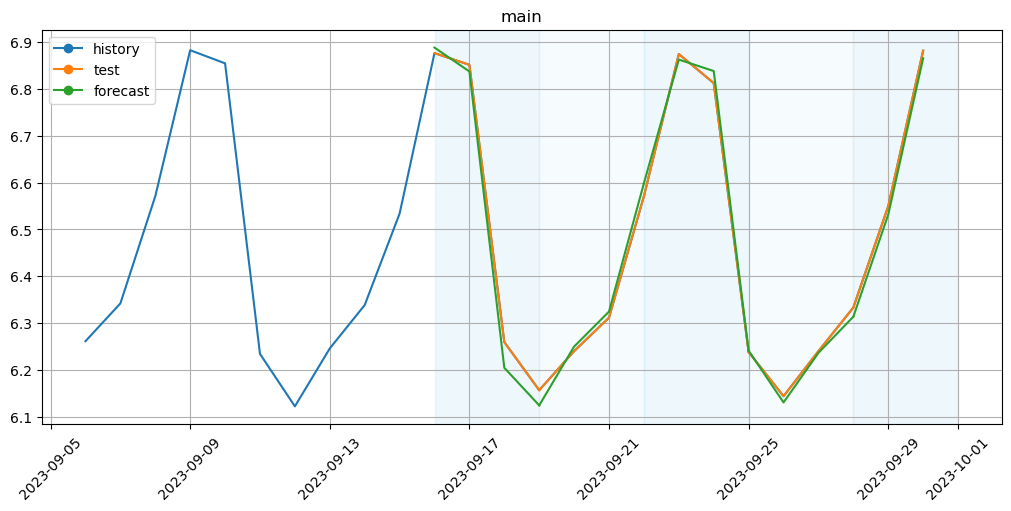

In [430]:
plot_backtest(forecast_df=forecast, ts=ts, history_len=10)

In [431]:
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580
3,NaiveModel,0.309069,4.648117,0.144704,0.380399
4,Pipeline: LinearPerSegmentModel with transform...,0.018410,0.285612,0.000517,0.021066
5,Pipeline: CatBoostMultiSegmentModel with trans...,0.018318,0.283624,0.000493,0.020656


ARIMA / SARIMA

In [432]:
# данные для нулевой пиццерии с агрегацией на весь день
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']
df['value'] = np.log(df['value'])
Train = df.loc[:'09.15.2023']
Test = df.loc['09.16.2023':]

In [433]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [434]:
from pmdarima import auto_arima
stepwise_fit = auto_arima(Train['value'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=187.699, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=134.263, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-20.601, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=185.699, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-49.016, Time=0.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-381.634, Time=0.59 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-68.174, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-118.297, Time=0.52 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-70.880, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-444.336, Time=1.01 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.40 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-724.516, Time=1.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-614.052, Tim

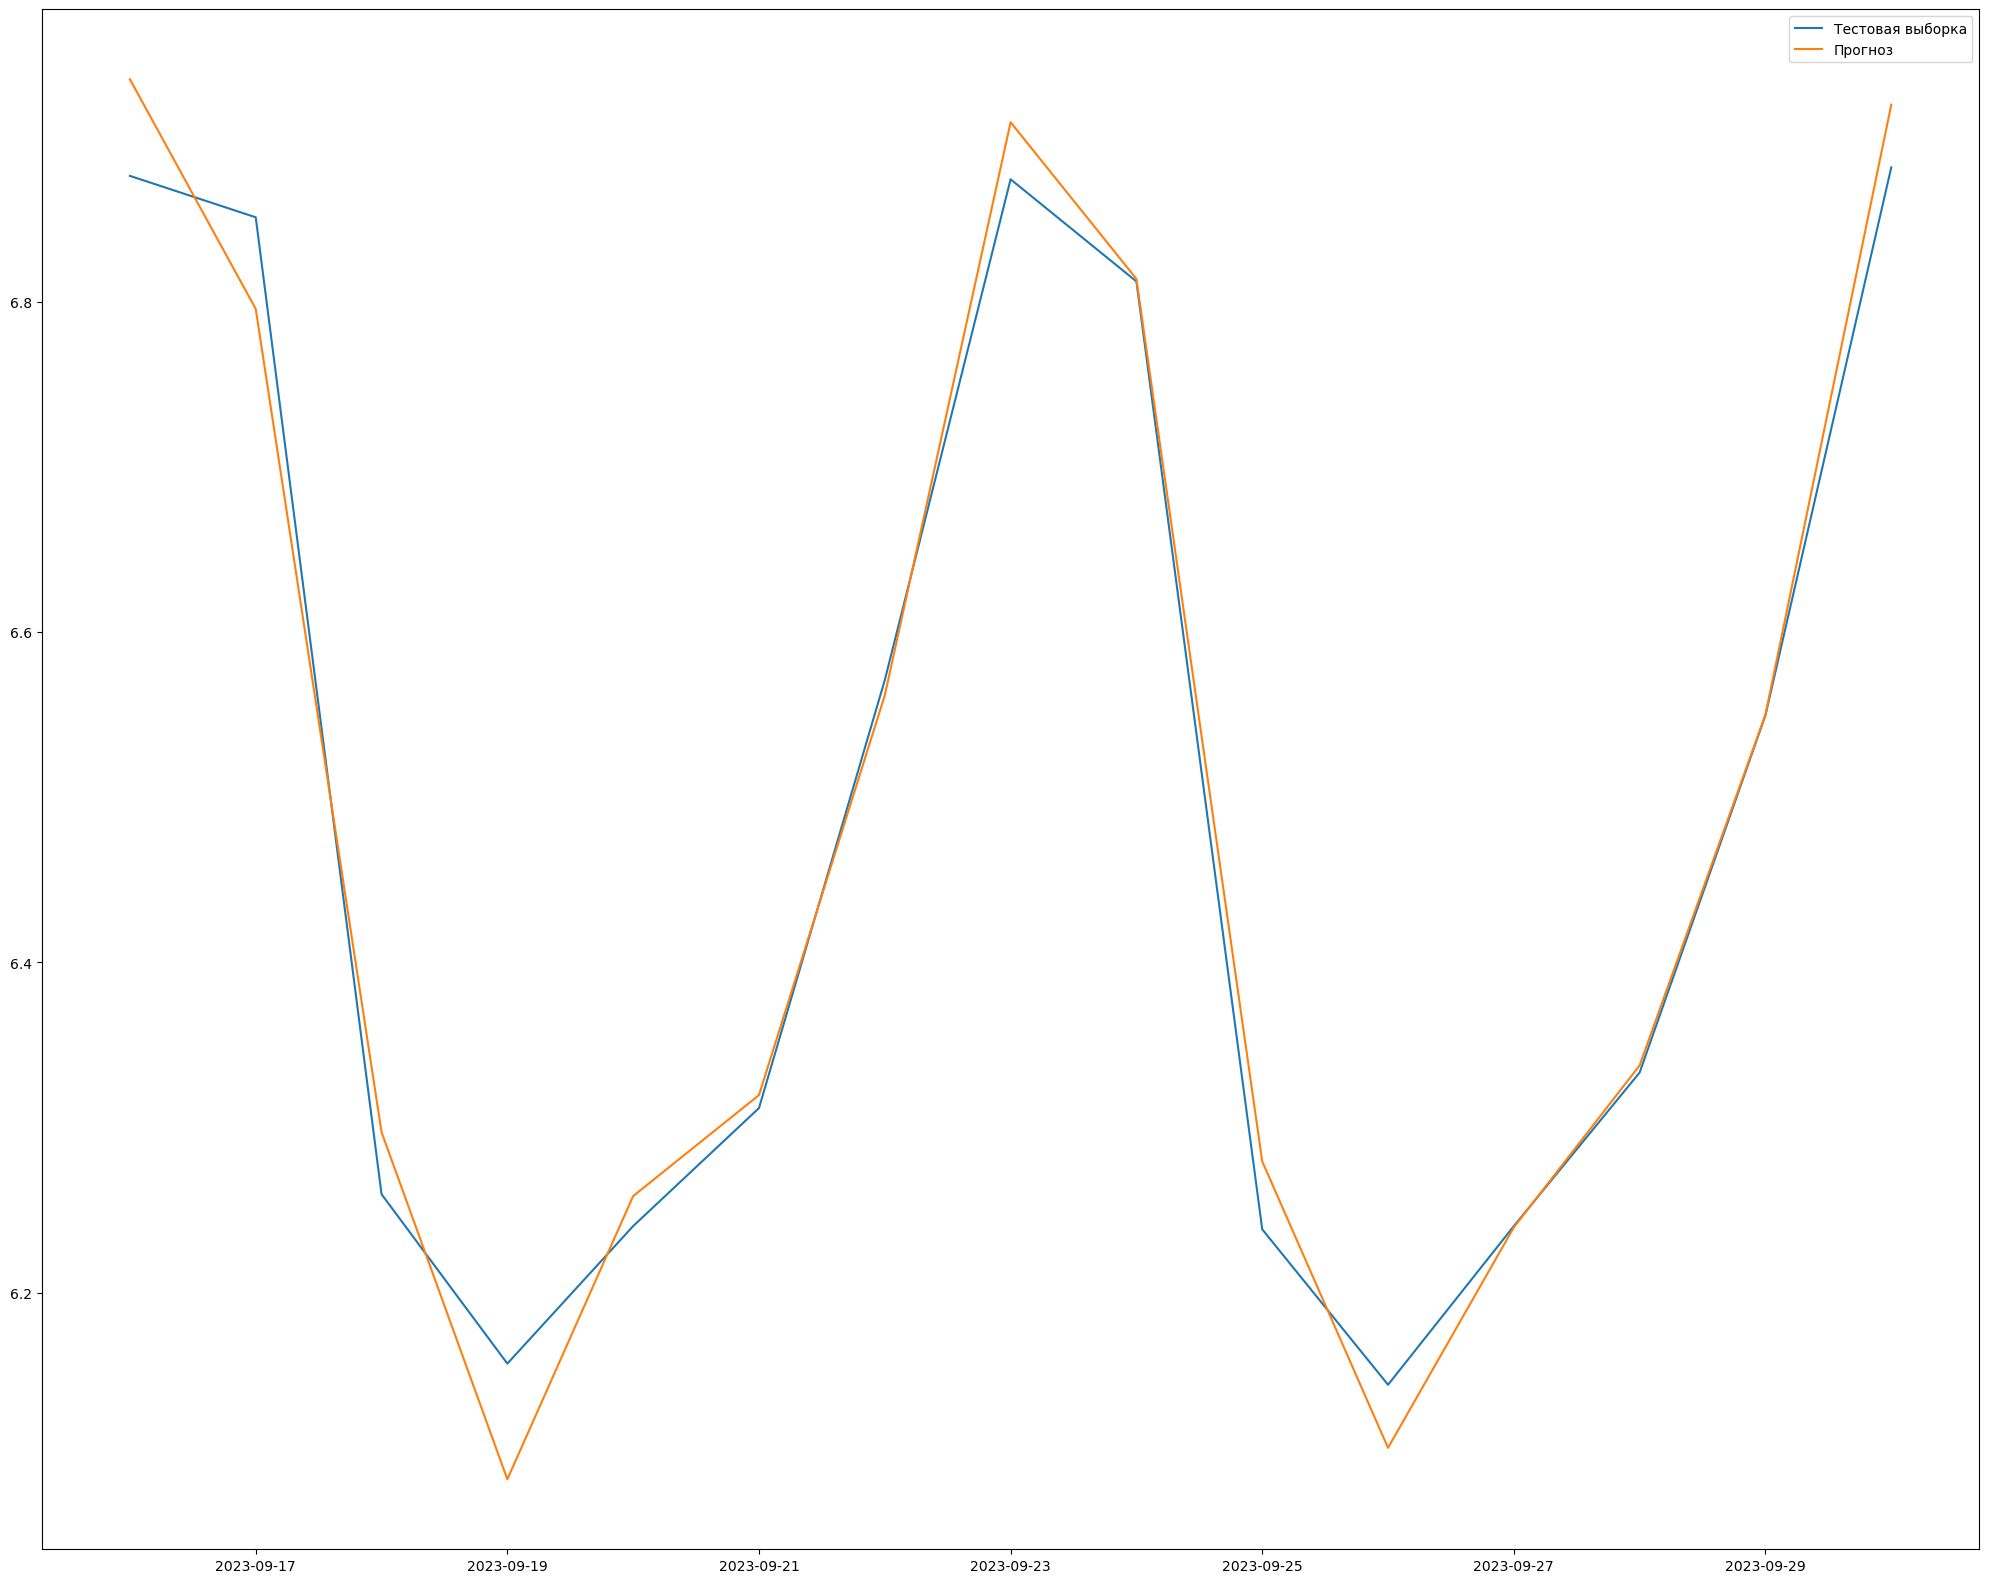

In [435]:
p, d, q = 5, 1, 5


# Построение ARIMA модели на обучающей выборке
model = ARIMA(Train['value'], order=(p, d, q))
results = model.fit()

# Построение прогноза на тестовой выборке
forecast_steps = len(Test)
forecast = results.get_forecast(steps=forecast_steps)

# Визуализация результата
plt.plot(Test['value'], label='Тестовая выборка')
plt.plot(forecast.predicted_mean, label='Прогноз')
plt.legend()
plt.show()

# Рассчитываем метрики на тестовой выборке
y_true = Test['value']
y_pred = forecast.predicted_mean
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [436]:
# Выводим метрики
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Squared Error (MSE): 0.0012737691394938144
Root Mean Squared Error (RMSE): 0.035689902486471074
Mean Absolute Error (MAE): 0.02771512764138488
Mean Absolute Percentage Error (MAPE): 0.43%


In [449]:
appending_data = {'method': 'ARIMA', 'MAE': mae, 'MAPE': mape, 'MSE': mse, 'RMSE': rmse} 
metrics_df = metrics_df.append(appending_data, ignore_index=True)
metrics_df

,method,MAE,MAPE,MSE,RMSE
0,Prophet,0.186648,0.028843,0.034980,0.187029
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580
3,NaiveModel,0.309069,4.648117,0.144704,0.380399
4,Pipeline: LinearPerSegmentModel with transform...,0.018410,0.285612,0.000517,0.021066
5,Pipeline: CatBoostMultiSegmentModel with trans...,0.018318,0.283624,0.000493,0.020656
6,ARIMA,0.027715,0.426606,0.001274,0.035690


In [451]:
metrics_df.sort_values('MAE')

,method,MAE,MAPE,MSE,RMSE
5,Pipeline: CatBoostMultiSegmentModel with trans...,0.018318,0.283624,0.000493,0.020656
4,Pipeline: LinearPerSegmentModel with transform...,0.018410,0.285612,0.000517,0.021066
6,ARIMA,0.027715,0.426606,0.001274,0.035690
1,linear regression with time_series_split,0.042189,0.006596,0.003655,0.059725
2,linear regression,0.049301,0.007441,0.003550,0.059580
0,Prophet,0.186648,0.028843,0.034980,0.187029
3,NaiveModel,0.309069,4.648117,0.144704,0.380399


Среднее по месяцам и годам

Решил добавить это значение в модель и посмотреть на изменение MAE (средней абсолютной ошибки)

In [ ]:
def code_mean(data, cat_feature, real_feature):
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [ ]:
data = df.copy()

df["month"] = df.index.month
df["year"] = df.index.year

df.head()

In [ ]:
code_mean(df, "month", "value")

In [ ]:
code_mean(df, "year", "value")

In [ ]:
def preprocess_data(data, lag_start=1, lag_end=8, date_cut='31.05.2023'):

    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data['value'].shift(i)

    data = data.dropna()

    data["month"] = data.index.month

    # считаем средние только по тренировочной части, чтобы избежать лика (data leak)
    data["month_average"] = list(map(code_mean(data.loc[:date_cut], "month", "value").get, data.month))

    # выкидываем закодированные средними признаки
    data.drop(["month"], axis=1, inplace=True)
    

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:date_cut].drop(["value"], axis=1)
    y_train = data.loc[:date_cut]["value"]
    X_test = data.loc['09.01.2023':].drop(["value"], axis=1)
    y_test = data.loc['09.01.2023':]["value"]

    return X_train, X_test, y_train, y_test

In [ ]:
df = pd.read_csv('second_scenario_with_noise.csv', index_col = 'Unnamed: 0')
df = pd.DataFrame(df['0'])
df.index = pd.to_datetime(df.index)
df=df.resample("D").agg(["sum"])
df.columns = ['value']

In [ ]:
X_train, X_test, y_train, y_test = preprocess_data(df)

X_train.shape, X_test.shape

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)

preds = lr.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(preds, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.grid(True)
plt.legend(loc="best")
plt.title(f"Linear regression\n Mean absolute error {mean_absolute_error(preds, y_test)} degrees");

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

y = pd.concat([y_train, y_test], axis=0)
X = pd.concat([X_train, X_test], axis=0)

errors = []

tscv = TimeSeriesSplit(n_splits=5)

for train_index, test_index in tscv.split(X):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    model = LinearRegression()
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    errors.append(mean_absolute_error(preds, y_test))

np.mean(errors)

# по итогу ошибки стали даже больше 